# HW4: ConvNets and activation patching

In this assignment you will implement a CNN for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset. Then you'll use `NNSight` to do some cool interpretability analysis (specifically, *activation patching*).

##Q1: Implement a simple CNN (20 points)

Begin by implementing a simple image classification CNN in pytorch. To do this, populate the `__init__` and `forward` methods. For now, your CNN can just be composed of two convolution layers and a linear layer.

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [4]:
# Starter code

# A simple convolutional neural network (two convolutional layers)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(8*8*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

##Q2: Train the thing (10 points)

Now write a training loop for your simple CNN. You should use early stopping with a validation set. Implement the train and evaluate functions.

Train should take a model which subclasses nn.Module, two DataLoaders, and an optimizer (see [torch.optim](https://https://pytorch.org/docs/stable/optim.html)), as well as a maximum epoch count and a patience for the early stopping. It may be helpful in the next question for train to return the performance on the validation set at each epoch.

Evaluate should take a model which subclasses nn.Module and a DataLoader. It should return both the overall model accuracy as well as the per class accuracy for each class.

In [5]:
train_set = torchvision.datasets.CIFAR10("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Starter code
device = 'cuda'
num_classes = 10

def train(model, train_loader, val_loader, optimizer, epochs, patience=3):
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    accs = []
    
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader): 
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        val_acc = evaluate(model, val_loader)
        accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else: 
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    return accs


# TODO: accuracy for each class 
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

Now create a validation split and use the train and evaluate methods to train your model.

In [6]:
train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

print(f'Train loader: {len(train_loader.dataset)}. Val loader: {len(val_loader.dataset)}. Test loader: {len(test_loader.dataset)}')

Train loader: 40000. Val loader: 10000. Test loader: 10000


In [8]:
model = SimpleCNN(num_classes).to(device)
adam = torch.optim.Adam(model.parameters(), lr=0.01)

valAccs_adam = train(model, train_loader, val_loader, adam, epochs=20, patience=5)
testAcc = evaluate(model, test_loader)
print("Best Validation accuracy(Adam): ", max(valAccs_adam))
print("Test accuracy(Adam): ", testAcc)

Early stopping at epoch 17
Best Validation accuracy(Adam):  0.6763
Test accuracy(Adam):  0.6031


##Q3: Compare optimization methods (10 points)

Now train the model with different optimizers and compare the performance. Try using the following optimizers:
* SGD
* Nesterov Gradient Descent
* Adagrad
* RMSProp
* Adam

Then plot the validation performance at each epoch and compare the optimizers.

Early stopping at epoch 12
Early stopping at epoch 7
Early stopping at epoch 8
Early stopping at epoch 13


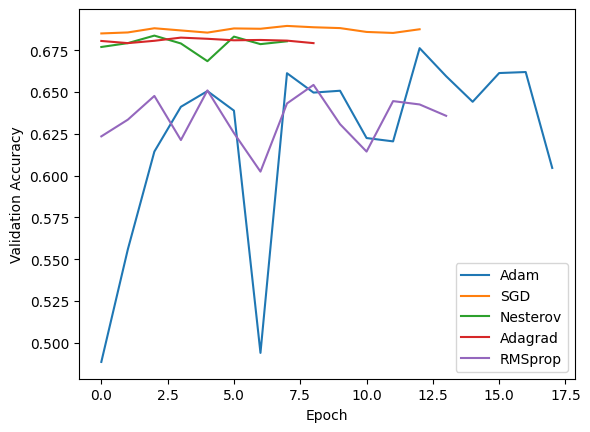

In [9]:
sgd = torch.optim.SGD(model.parameters(), lr=0.01)
valAccs_sgd = train(model, train_loader, val_loader, sgd, epochs=20, patience=5)

ngd = torch.optim.SGD(model.parameters(), lr=0.01, nesterov=True, momentum=0.9)
valAccs_ngd = train(model, train_loader, val_loader, ngd, epochs=20, patience=5)

adagrad = torch.optim.Adagrad(model.parameters(), lr=0.01)
valAccs_adagrad = train(model, train_loader, val_loader, adagrad, epochs=20, patience=5)

rmsprop = torch.optim.RMSprop(model.parameters(), lr=0.01)
valAccs_rmsprop = train(model, train_loader, val_loader, rmsprop, epochs=20, patience=5)

plt.plot(valAccs_adam, label='Adam')
plt.plot(valAccs_sgd, label='SGD')
plt.plot(valAccs_ngd, label='Nesterov')
plt.plot(valAccs_adagrad, label='Adagrad')
plt.plot(valAccs_rmsprop, label='RMSprop')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

##Q4: Make a more accurate CNN (10 points)

At this point, your model's performance should still be relatively low (probably ~60%), even with the best optimization method.

To improve further, you'll need to modify your architecture. Define a model that has an arbitrary number of convolution layers before a fully connected layer. Implement the `__init__` and `forward` methods below. The `__init__` method should take a convolutions parameter that controls the number of convolution layers in the model.

In [21]:
# Starter code

# A convolutional neural network with arbitrary depth
class MultiLayeredCNN(nn.Module):
    def __init__(self, convolutions: list, num_classes: int = 10):
        super(MultiLayeredCNN, self).__init__()
        layers = []
        for i in range(len(convolutions)-1):
            in_channels = convolutions[i]
            out_channels = convolutions[i+1] 
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(8 * 8 * (convolutions[-1]), num_classes) 
        

        

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

Now create and train models with varying numbers of convolution layers. You should create a model with 2, 3, and 4 convolution layers each. Record their performance on the validation set at each epoch and plot the results below to compare the models.

In [23]:
CNN2L = MultiLayeredCNN([3, 16, 32]).to(device)
grad = torch.optim.SGD(CNN2L.parameters(), lr=0.01)

valAccs_2L = train(CNN2L, train_loader, val_loader, grad, epochs=1, patience=5)

CNN3L = MultiLayeredCNN([3, 16, 32, 64]).to(device)
grad = torch.optim.SGD(CNN3L.parameters(), lr=0.01)
valAccs_3L = train(CNN3L, train_loader, val_loader, grad, epochs=1, patience=5)

CNN4L = MultiLayeredCNN([3, 16, 32, 64, 128]).to(device)
grad = torch.optim.SGD(CNN4L.parameters(), lr=0.01)
valAccs_4L = train(CNN4L, train_loader, val_loader, grad, epochs=1, patience=5)

plt.plot(valAccs_2L, label='2 convolutions')
# plt.plot(valAccs_3L, label='3 convolutions')
# plt.plot(valAccs_4L, label='4 convolutions')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1024 and 4096x10)

## Q5: Interpretability! Or, activation patching ConvNets with `NNSight` (50 points)

We're going to play with **[activation patching](https://nnsight.net/notebooks/tutorials/ioi_patching/)** here. The idea is to **intervene** on model activations during execution to try and tease out how the model performs a given task (here, image classification).

What will we be looking at? Well, the ConvNet we trained seems to be able to do a fairly OK job at discriminating between the numbers 1 and 7; but this is kind of tricky! Can we isolate key activations in the model that allow for this?

That's the idea behind activation patching. We will run different inputs through the model—an image of a 1, an image of a 7—and then intervene by replacing (or "patching") in activations from the former into the latter. Then we measure how much this shifts the prediction towards 1.

We'll run two input images through the model—a 1 and a 7—and patch in activations for different **channels** from the former to the latter at the penultimate layer in our `MultiLayeredCNN`. ([Here is a refresher on channels in ConvNets](https://d2l.ai/chapter_convolutional-neural-networks/channels.html).) Sometimes we speculate that different channels serve as distinct feature detectors — we're essentially probing this assumption here with activation patching!

First, we need a model to intervene on! Let's take the best performing model and optimizer from the above experiments, and re-train it so that we can try and probe how it works.

In [70]:
# Retrain your best model here!
conv_channels = [3, 16, 32, 64]
model = MultiLayeredCNN(conv_channels).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scores = train(model, train_loader, val_loader, optim, epochs=20, patience=5)

TypeError: 'list' object cannot be interpreted as an integer

Your task in this question can be broken down as follows

(1) First write code to extract activations when you pass an arbitrary *test* image through your trained model; you should use `NNsight` for this. To keep things relatively simple, take activations over all channels from the last convolutional layer output. **We are interested in whether one of the channels at this layer is especially important for discriminating 7s from 1s**.

(2) You will want to record **logits** and differences of **logits** between the two classes of interest, here (at least initially) 1 and 7. You can roughly follow this `NNSight` tutorial on patching here! https://nnsight.net/notebooks/tutorials/activation_patching/. In our case, you can view the 'clean' pass as just passing an image of a 7, and the 'corrupt' pass an image of a 1 (again, at least initially). As in the linked tutorial, we will use differences in logits (between 7 and 1) as our primary measure: Denote this by $\Delta (7,1)$.

(3) Iterate over all channels (32 or 64) in forward passes conditioned on the 7 image input, patch in the corresponding activations (from the 1 pass) and take the (patched) difference in logits. Finally, the measure we care about is:

\begin{align}
%\Delta(7,1) \text{ for patched}  - \Delta(7,1) \text{ for clean 1}
\frac{\Delta(7,1) \text{ for patched}  - \Delta(7,1) \text{ for 1}}{\Delta(7,1) \text{ for 7} - \Delta(7,1) \text{ for 1}}
  \end{align}

Where again $\Delta(7,1)$ (differences) are between the scores (logits) given to 7 and 1, respectively, i.e., $\Delta(7,1) = \tilde{y}_7 - \tilde{y}_1$, where $\tilde{y}_j$ is the *logit* (pre-softmax) score assigned to class $j$.
The denominator is just a normalizing term so that the quantity will usually—though not always—be between 0 and 1.

If this is small, then the gap between 7 and 1 is closing as we patch, relative to the difference observed in the "clean run" of 7s through the model.


(4) Once you have calculated the above for each channel, plot these values: Make a bar graph such that the $x$ axis is the channel, and the $y$ value the score.

(5) Get this working for a single pair of images (one image of a 1, one of a 7, sampled at random from the test set). Then, get it working for a batch of samples (one batch of 1s, one batch of 7s). You should take means for the $\Delta(7, 1)$ values. For patching, you can arbitrarily take 1 and 7 images from the respective batches and patch activations from the former into the latter. Remake the plot.

(6) Now, repeat the experiment with 7s vs. 3s (instead of 1s). Regenerate the plot.

(7) Finally, write up your interpretation of your results.


In [72]:
# Install nnsight
!pip install nnsight

Defaulting to user installation because normal site-packages is not writeable


In [73]:
import random

def get_sample_of_class(class_idx, batch_size=1):
    images = []
    for image, label in test_loader:
        for i in range(len(label)):
            if label[i] == class_idx:
                images.append(image[i])
            if len(images) >= batch_size:
                break
        if len(images) >= batch_size:
            break
    return images

In [74]:
batch_of_ones = get_sample_of_class(1, batch_size=8)
batch_of_sevens = get_sample_of_class(7, batch_size=8)

In [75]:
from nnsight import NNsight

model_nn = NNsight(model)
print(model.cnns)
print(model.fc)

# ModuleList(
#   (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# )
# Linear(in_features=65536, out_features=10, bias=True)

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'SimpleCNN' object has no attribute 'cnns'

In [ ]:

def run_patching_experiment(model_nn, A_batch, B_batch, A_idx=6, B_idx=0,
                            conv_idx=2, num_channels=64):
  '''
  Run activation patching experiment over instances in the A and B batches;
  return scores that indicate the importance of each channel output from the
  specificed convolution layer (conv_idx).

  model_nn: NNsight-wrapped trained ConvNet for digit classification
  A_batch: batch of images of class A (e.g., 7s)
  B_batch: batch of images of class B (e.g., 1s)
  '''

  # Your code here!

  return channel_deltas, logit_diffs, logit_diffA, logit_diffB

In [ ]:
channel_deltas, logit_diffs, logit_diffA, logit_diffB = run_patching_experiment(
    model_nn, batch_of_sevens, batch_of_ones, A_idx=6, B_idx=0)

Note: your plot may not look (exactly) like the one below just do to randomness in SGD! That is, you may find different 'important' filters for distinguishing b/w 1 and 7. That's OK.

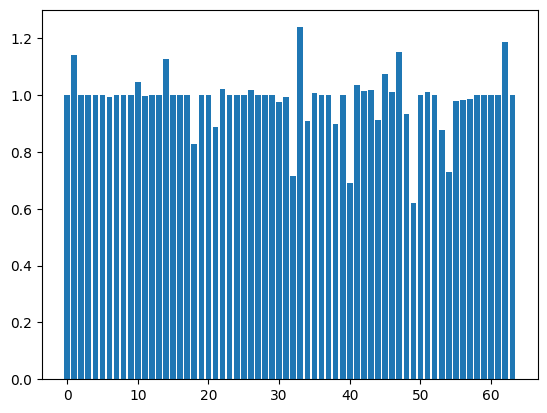

In [ ]:
plt.bar(range(len(channel_deltas)), channel_deltas)
plt.show()

In [ ]:
min_score_idx = np.argmin(channel_deltas)
print("Important channel for 1 and 7 is", min_score_idx)
print(f"Clean logit difference [y_7 - y_1] (for pass of 7s): {logit_diffA.value:.3f}")
print(f"Intervened logit difference (after activation patching): {logit_diffs[min_score_idx].item():.3f}")

Important channel for 1 and 7 is 49
Clean logit difference [y_7 - y_1] (for pass of 7s): -447.472
Intervened logit difference (after activation patching): -667.736


And now, let's repeat with 7 and 3

In [ ]:
batch_of_threes = get_sample_of_class(3, batch_size=8)

In [ ]:
channel_deltas, logit_diffs, logit_diffA, logit_diffB = run_patching_experiment(
    model_nn, batch_of_sevens, batch_of_threes, A_idx=6, B_idx=2)

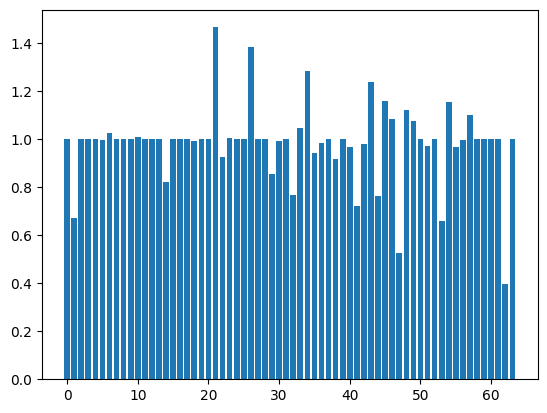

In [ ]:
plt.bar(range(len(channel_deltas)), channel_deltas)
plt.show()

In [ ]:
min_score_idx = np.argmin(channel_deltas)
print("Important channel for 3 and 7 is", min_score_idx)
print(f"Clean logit difference: {logit_diffA.value:.3f}")
print(f"Intervened logit difference: {logit_diffs[min_score_idx].item():.3f}")

Important channel for 3 and 7 is 62
Clean logit difference: -453.995
Intervened logit difference: -339.084


## Interpretation

*Enter here*